## Modelling LSTM
Spelling error: 'compound' is mistakenly written as 'compund' and I noticed it after complete coding.

In [1]:
print('STOCK PREDICTION USING RNN LSTM')
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

STOCK PREDICTION USING RNN LSTM


d:\python362_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Plotting the data

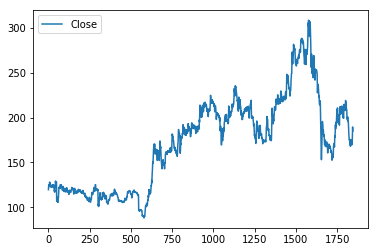

<Figure size 432x288 with 0 Axes>

In [2]:
data_csv = pd.read_csv('final_data_hbl.csv')

data_csv[['Close']].plot()
plt.show()
plt.clf()

### Calculating the length of data to use

In [3]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data_csv)
print("total_data:", total_data)

total_data: 1846


### Arranging the data

In [4]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#close, compund, neg, neu, pos, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
yt = data_csv.iloc[start:total_data,8] #close
yt1 = data_csv.iloc[start:total_data,1] #compund
yt2 = data_csv.iloc[start:total_data,2] #neg
yt3 = data_csv.iloc[start:total_data,3] #neu
yt4 = data_csv.iloc[start:total_data,4] #pos
yt5 = data_csv.iloc[start:total_data,5] #open
yt6 = data_csv.iloc[start:total_data,6] #high
yt7 = data_csv.iloc[start:total_data,7] #low
vt = data_csv.iloc[start:total_data,9] #volume

print("yt head (close) :")
print(yt.head())

yt head (close) :
1    121.87
2    124.93
3    124.98
4    124.99
5    123.56
Name: Close, dtype: float64


### Shifting the data by 1

In [5]:
#shift next day close and next day compund
yt_ = yt.shift(-1) #shifted close
yt1_ = yt1.shift(-1) #shifted compund

#taking only: close, next_close, compund, next_compund, volume, open, high, low
data = pd.concat([yt, yt_, yt1, yt1_, vt, yt5, yt6, yt7], axis=1)
data.columns = ['yt', 'yt_', 'yt1', 'yt1_','vt', 'yt5', 'yt6', 'yt7']

data = data.dropna()
     
print(data[:10])

        yt     yt_     yt1    yt1_       vt     yt5     yt6     yt7
1   121.87  124.93 -0.6996 -0.9442   627959  119.50  122.30  119.50
2   124.93  124.98 -0.9442 -0.7906  1506848  121.75  126.45  121.40
3   124.98  124.99 -0.7906 -0.5859   773913  124.50  125.89  123.75
4   124.99  123.56 -0.5859 -0.9723   376749  125.84  126.06  124.69
5   123.56  123.01 -0.9723 -0.9578   166214  126.24  126.80  123.00
6   123.01  127.87 -0.9578 -0.3818   329849  123.61  124.50  122.75
7   127.87  127.60 -0.3818 -0.7184   788687  124.00  128.90  123.89
8   127.60  126.70 -0.7184 -0.8720   156709  128.70  128.97  126.25
9   126.70  126.79 -0.8720 -0.5994   278339  128.48  128.48  126.45
10  126.79  125.58 -0.5994 -0.7506   195832  127.75  128.00  126.34


### Separating data into x and y
**Approach:** Training the machine using ***compund, close price, and next_compund*** to predict ***next_close price***.

In [6]:
# target variable - closed price
# after shifting
y = data['yt_'] #next_close

# close, compund, next_compund, volume, open, high, low   
cols = ['yt', 'yt1', 'yt1_', 'vt', 'yt5', 'yt6', 'yt7']
x = data[cols]

### Preprocessing

In [7]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

### Train Test Split

In [8]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

### RNN LSTM Model

In [9]:
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential ()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

print(model.summary())

model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)


d:\python362_64\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(25, return_sequences=True, activation="tanh", input_shape=(7, 1), recurrent_activation="hard_sigmoid")`
  # Remove the CWD from sys.path while we load stuff.
d:\python362_64\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activity_regularizer=<keras.reg..., activation="linear", units=1)`
d:\python362_64\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 25)             2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 25)             5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
__________

Epoch 65/100
1180/1180 [==============================] - 1s 621us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 66/100
1180/1180 [==============================] - 1s 615us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 67/100
1180/1180 [==============================] - 1s 615us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 68/100
1180/1180 [==============================] - 1s 617us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 69/100
1180/1180 [==============================] - 1s 608us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 70/100
1180/1180 [==============================] - 1s 617us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 71/100
1180/1180 [==============================] - 1s 644us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 72/100
1180/1180 [==============================] - 1s 628us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 73/100
1180/1180 [==============================] - 1s 618us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 74/100
1180/1180 [======================

### Score Calculation

In [10]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )

367/367 [==============================] - 1s 3ms/step
in train MSE =  0.0011
in test MSE =  0.010530787610533462


### Saving model

In [11]:
model_json = model.to_json()
with open("model_rms100e_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_rms100e_new.h5")
print("Saved model to disk")

Saved model to disk


### Predicting on unseen data

Inputs: (None, 7, 1)
Outputs: (None, 1)
Actual input: (367, 7, 1)
Actual output: (367, 1)
prediction data:
[189.62741]
actual data
[[272.46     0.7351  -0.9849 ... 274.5    283.99   259.46  ]
 [262.89    -0.9849  -0.3784 ... 275.     275.9    261.25  ]
 [261.75    -0.3784  -0.9716 ... 265.28   265.5    259.5   ]
 ...
 [174.8     -0.8853  -0.9939 ... 172.     176.49   171.    ]
 [181.72    -0.9939  -0.6908 ... 175.     183.54   174.02  ]
 [189.47    -0.6908   0.9178 ... 181.     189.74   180.02  ]]


d:\python362_64\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


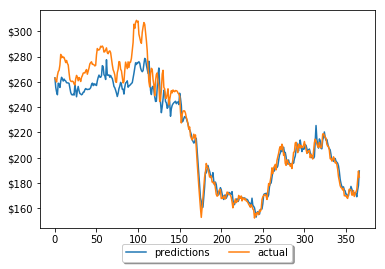

<Figure size 432x288 with 0 Axes>

In [12]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

#########################################################################
'''Plotting'''
plt.plot(pred, label="predictions")

y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))
plt.plot([row[0] for row in y_test], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.show()
plt.clf()
